In [283]:
import pandas as pd
import numpy as np
import os

### Mapillary counts

In [3]:
img_ct = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/tag_counts/germany_image_counts.csv")
img_ct.image_count.sum()

about 170M images in Germany (query data Nov. 2023)

In [5]:
meta = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_metadata.csv")

In [6]:
len(meta) / img_ct.image_count.sum()

0.3026986736703738

30% sample

In [7]:
meta["date"] = pd.to_datetime(meta.captured_at,  unit="ms")

In [8]:
meta["year"] = pd.to_datetime(meta.captured_at,  unit="ms").dt.year

In [9]:
meta.value_counts("year").sort_index()

year
1899           9
1921           4
1970          96
1980         459
1994          18
2000           2
2002        1299
2004          48
2005           5
2006         849
2007         320
2008        1405
2009        2129
2010        3010
2011        7734
2012       11964
2013        9228
2014      620403
2015     1203190
2016     2040851
2017     2915628
2018     3688915
2019     5432688
2020     8348287
2021    10028970
2022     8821842
2023     8060625
2024      257145
Name: count, dtype: int64

In [10]:
meta.head()

,tile_id,id,sequence_id,captured_at,compass_angle,is_pano,creator_id,lon,lat,date,year
0,8472_5495_14,1707356142945280,NFZVQseCHAkdM93c8TBX2p,1646408953313,235.849106,False,104536648714052,6.163904,50.854445,2022-03-04 15:49:13.313,2022
1,8472_5495_14,237587568154199,fnSJ7GaGLWXTQciojBhBOw,1441019869000,330.000000,False,103390745232765,6.165894,50.860008,2015-08-31 11:17:49.000,2015
2,8472_5495_14,975748309981229,NFZVQseCHAkdM93c8TBX2p,1646408904312,230.319958,False,104536648714052,6.166087,50.855450,2022-03-04 15:48:24.312,2022
3,8472_5495_14,168724596206843,TuRPvl8KZ0JDIYLEoFwbr4,1694435326000,143.651000,False,103550301888099,6.165631,50.854021,2023-09-11 12:28:46.000,2023
4,8472_5495_14,495587888161346,JEn6aNGUCtcuSafGMlEncw,1564562164000,179.258416,False,103390745232765,6.171484,50.850364,2019-07-31 08:36:04.000,2019


In [11]:
# take out date outliers (any dates before launch date 2013)
meta[meta["captured_at"] > 1363074956000]["date"].describe()

count                         51427459
mean     2020-10-04 19:29:34.389486848
min                2013-03-16 13:35:26
25%                2019-06-23 16:25:13
50%      2021-03-17 12:41:47.158000128
75%         2022-06-12 10:46:37.500000
max                2024-01-16 16:12:56
Name: date, dtype: object

In [12]:
np.percentile(meta[meta["captured_at"] > 1363074956000]["date"], 50)

KeyboardInterrupt: 

<Axes: >

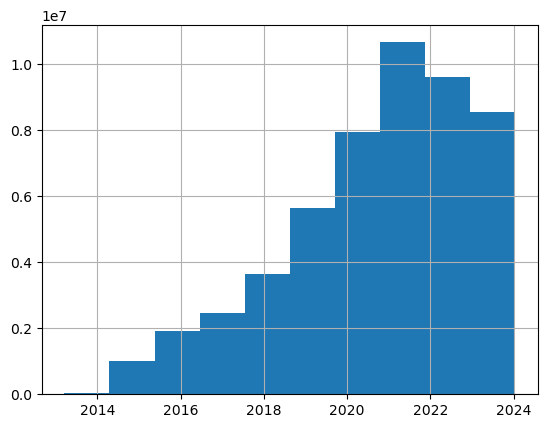

In [ ]:
meta[meta["captured_at"] > 1363074956000]["date"].hist()

In [ ]:
meta["date"].describe()

count                         51457123
mean     2020-10-02 15:08:45.973085440
min                1899-11-30 08:09:47
25%         2019-06-23 11:53:59.476000
50%                2021-03-15 08:50:17
75%                2022-06-12 05:47:11
max                2024-01-16 16:12:56
Name: date, dtype: object

### OSM counts

In [ ]:
osm_data = pd.read_csv('/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/OSM/osm_surface_tag_counts_germany.csv')

In [ ]:
osm_sum = osm_data["ct"].sum()

osm_data["percentage"] = osm_data["ct"] / osm_sum * 100

In [ ]:
osm_data

,ct,surface,percentage
0,3320158,asphalt,46.877943
1,1064144,paving_stones,15.024852
2,433195,ground,6.116363
3,374243,gravel,5.284008
4,363550,grass,5.133032
5,328231,paved,4.634356
6,266713,compacted,3.765772
7,148819,concrete,2.101204
8,145985,dirt,2.061190
9,135753,sett,1.916722


In [ ]:
osm_data["surface_clean"] = osm_data["surface"].replace(
        [
            "compacted",
            "gravel",
            "ground",
            "fine_gravel",
            "dirt",
            "grass",
            "earth",
            "sand",
        ],
        "unpaved",
    )

osm_data["surface_clean"] = osm_data["surface_clean"].replace(
        ["cobblestone", "unhewn_cobblestone"], "sett"
    )

In [ ]:
osm_data = pd.DataFrame(osm_data.groupby("surface_clean")["ct"].sum())
osm_data["percentage"] = osm_data["ct"] / osm_sum * 100

In [ ]:
osm_data.sort_values("percentage")

,ct,percentage
surface_clean,,
woodchips,1290,0.018214
rock,2431,0.034324
mud,2775,0.039181
stone,3029,0.042767
metal,8790,0.124108
grass_paver,9614,0.135742
concrete:lanes,11963,0.168908
concrete:plates,21824,0.308137
wood,26647,0.376234


In [ ]:
osm_data[osm_data["surface"].isin(["sett", "cobblestone"])].sum()

ct                     191691
surface       settcobblestone
percentage           2.706522
dtype: object

In [ ]:
# number considered of tiles
df = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_selection.csv", index_col=False)
len(df)

5279

In [ ]:
df["tile_id"] = [str(x) + "_" + str(y) for x, y in zip(df["x"], df["y"])]
df.tile_id.nunique()

3996

In [ ]:
# number of images
df = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_metadata.csv", index_col=False)

In [ ]:
len(df)

51457123

In [ ]:
# annotations of batch 1
df_V4 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V6/metadata/annotations_combined.csv", index_col=False)
df_V4.groupby(["surface", "smoothness"]).size()

surface        smoothness  
asphalt        bad              29
               excellent       484
               good            727
               intermediate    220
concrete       bad              46
               excellent        63
               good            240
               intermediate    191
paving_stones  bad               7
               excellent        99
               good            334
               intermediate    108
sett           bad             183
               good             36
               intermediate    275
unpaved        bad             268
               intermediate    247
               very_bad        110
dtype: int64

In [ ]:
sum(df_V4.nostreet.notna()) / len(df_V4)

0.18621456364647027

In [ ]:
# annotations of batch V5_c2
df_V5c2 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V5_c2/metadata/annotations_combined.csv", index_col=False)
sum(df_V5c2.nostreet.notna()) / len(df_V5c2)

0.39542143600416235

In [8]:
# number of images with a tag
df_tag = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/img_metadata_with_tags.csv", index_col=False)

/var/folders/m7/jb7xk8h91p541g43zv2r8l740000gn/T/ipykernel_20036/80938205.py:2: DtypeWarning: Columns (9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tag = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/img_metadata_with_tags.csv", index_col=False)


In [9]:
len(df_tag)

14246142

In [ ]:
# V7
ann1 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V5_c2/metadata/V5_c2_annotator1.csv", index_col=False)
ann2 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V5_c2/metadata/V5_c2_annotator2.csv", index_col=False)

df = pd.concat([ann1, ann2], ignore_index=True)
df.loc[df.nostreet.notna(),"surface"] = "nostreet"
df.loc[df.nostreet.notna(),"smoothness"] = "nostreet"
df.groupby(["surface", "smoothness"]).size() 

## creator names

In [68]:
!curl 'https://graph.mapillary.com/148771344320493?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/293245499014573?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/133978728960378?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/129178263353193?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/291493615899057?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/828495164980463?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/137193541781677?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/149787357161377?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'

{"id":"148771344320493","creator":{"username":"macsico","id":"108354611399818"}}

python(80358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


{"id":"293245499014573","creator":{"username":"zoegglmeyr","id":"110552844504419"}}

python(80359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


{"id":"133978728960378","creator":{"username":"carlheinz","id":"100232345559807"}}

In [ ]:
len(meta[meta["captured_at"] < 1394610956000])

43222

## Annotation ratio

In [161]:

def clean_smoothness(metadata):
    """Clean smoothness column of metadata dataframe according to defined OSM smoothness values

    Args:
        metadata (df): dataframe with image metadata, including column "smoothness"

    Returns:
        df: dataframe with cleaned smoothness column "smoothness_clean"
    """
    metadata["smoothness"] = metadata.smoothness.str.strip()
    metadata["smoothness_clean"] = metadata["smoothness"].replace(
        [
            "horrible",
            "very_horrible",
            "impassable",
            "very_bad",
        ],
        "very bad",
    )

    metadata["smoothness_clean"] = metadata["smoothness_clean"].replace(
        ["perfect", "very_good"], "excellent"
    )
    return metadata


def clean_surface(metadata):
    """Clean surface column of metadata dataframe according to defined OSM surface values

    Args:
        metadata (df): dataframe with image metadata, including column "surface"

    Returns:
        df: dataframe with cleaned surface column "surface_clean"
    """
    metadata["surface"] = metadata.surface.str.strip()
    metadata["surface_clean"] = metadata["surface"].replace(
        [
            "compacted",
            "gravel",
            "ground",
            "fine_gravel",
            "dirt",
            "grass",
            "earth",
            "sand",
        ],
        "unpaved",
    )
    metadata["surface_clean"] = metadata["surface_clean"].replace(
        ["cobblestone", "cobblestone:flattened", "unhewn_cobblestone"], "sett"
    )
    metadata["surface_clean"] = metadata["surface_clean"].replace(
        ["concrete:plates", "concrete:lanes"], "concrete",
    )
    return metadata

In [162]:
#annotations = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V6/metadata/annotations_combined.csv", index_col=False)
annotations = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/v12/metadata/annotations_combined.csv", index_col=False, dtype={"image_id": str})

# anything in annotation went through combined prediction (except batch 1: "V4", "V5_c0")
# for simplicity, remove entirely here
annotations = annotations[~annotations.input_version.isin(["V4", "V5_c0"])].copy()

In [163]:
metadata = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_image_selection_metadata.csv", index_col=False)
metadata2 = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v4/v4_train_image_selection_metadata.csv", index_col=False)
metadata_full = pd.concat([metadata, metadata2], ignore_index=True)
metadata = metadata_full[metadata_full.id.isin(annotations.image_id)]

In [164]:
group_by_annot = ["surface", "smoothness"]
group_by_osm = ["surface_clean", "smoothness_clean"]

In [165]:
#original_class_counts = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/original_class_counts.csv", index_col=False)
#remaining_class_counts = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/remaining_classes_after_V8.csv", index_col=False)

# how many hits per class?
tp_class_counts = pd.DataFrame(annotations.groupby(group_by_annot).size())

In [166]:
df = (
    annotations[["image_id", "surface", "smoothness"]]
      .set_index("image_id")
      .join(metadata[["id", "surface_clean", "smoothness_clean"]].set_index("id"), how="inner", rsuffix='_osm')
)

In [167]:
#df[(df.surface =="paving_stones") & (df.smoothness == "bad")]

In [168]:
incorrect_surface = df[df.surface != df.surface_clean]
incorrect_surface = pd.DataFrame(incorrect_surface.groupby(group_by_osm).size())

In [169]:
if group_by_annot == ["surface"]:
    label_as_osm = pd.DataFrame(df[(df.surface == df.surface_clean)].groupby(group_by_annot).size())
else:
    label_as_osm = pd.DataFrame(df[(df.surface == df.surface_clean) & (df.smoothness == df.smoothness_clean)].groupby(group_by_annot).size())

In [170]:
original_class_counts = pd.DataFrame(metadata_full.groupby(group_by_osm).size())

In [171]:
remaining_class_counts = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/remaining_classes_after_V12.csv", index_col=False)

In [172]:
remaining_class_counts = remaining_class_counts.groupby(group_by_osm).sum()

In [173]:
tp_class_counts.columns=["tp"]
original_class_counts.columns=["orig_counts"]
label_as_osm.columns=["label_as_osm"]
incorrect_surface.columns=["incorrect_surface"]

In [174]:
osm_tag_counts = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/OSM/osm_tag_counts_germany.csv")

In [175]:
osm_tag_counts.surface = osm_tag_counts.surface.str.strip()
osm_tag_counts.smoothness = osm_tag_counts.smoothness.str.strip()

In [176]:
osm_tag_counts = clean_surface(osm_tag_counts)
osm_tag_counts = clean_smoothness(osm_tag_counts)

In [177]:
if group_by_annot == ["surface"]:
    drop_col = ["surface", "smoothness", "smoothness_clean"]
else:
    drop_col = ["surface", "smoothness"]

osm_tag_counts = osm_tag_counts.drop(drop_col, axis=1).groupby(group_by_osm).sum()

In [178]:
osm_tag_counts["OSM_share"] = round(osm_tag_counts.ct / sum(osm_tag_counts.ct)* 100, 2)

In [179]:
cts = (original_class_counts
 .join(remaining_class_counts, on=group_by_osm, how="left")
 .join(tp_class_counts, on=group_by_osm, how="left")
 .join(incorrect_surface, on=group_by_osm, how="left")
 .join(label_as_osm, on=group_by_osm, how="left")
 .join(osm_tag_counts, how="left")
 .fillna(0)
)

In [180]:
# how many did we annotate?
cts["annotated_counts"] = cts.orig_counts - cts.remaining_counts
cts["annotated_counts_only_correct_surface"] = cts.annotated_counts - cts.incorrect_surface
cts["annotation_ratio"] = (cts.tp / cts.annotated_counts).round(3) * 100
cts["correct_OSM/tp"] = round(cts.label_as_osm / cts.tp * 100)
cts["correct_OSM/annotation_counts"] = round(cts.label_as_osm / cts.annotated_counts * 100, 2)
cts["correct_OSM/annotation_counts_only_correct_surface"] = round(cts.label_as_osm / cts.annotated_counts_only_correct_surface * 100, 2)
cts["times_better"] = round(cts["correct_OSM/annotation_counts"] / cts.OSM_share, 2)
cts["times_better_correct_surface"] = round(cts["correct_OSM/annotation_counts_only_correct_surface"] / cts.OSM_share, 2)

In [181]:
cts

orig_counts  remaining_counts   tp  \
surface_clean smoothness_clean                                       
asphalt       bad                      1348               0.0  109   
              excellent                2000            1690.0  528   
              good                     2000            1690.0  982   
              intermediate             2000               0.0  531   
concrete      bad                       298               0.0   34   
              excellent                 803               0.0  165   
              good                     1469            1155.0  237   
              intermediate             1052             542.0  179   
paving_stones bad                       569               0.0   30   
              excellent                2000               0.0  300   
              good                     2000            1689.0  551   
              intermediate             2000               0.0  151   
sett          bad                      1951               0.0  431   
              good                     1118               0.0   78   
              intermediate             2000            1687.0  566   
unpaved       bad                      2000            1639.0  237   
              intermediate             2000            1640.0  202   
              very_bad                 1159             546.0  128   

                                incorrect_surface  label_as_osm        ct  \
surface_clean smoothness_clean                                              
asphalt       bad                             305            82    7505.0   
              excellent                        42           122  219803.0   
              good                             51           127  316996.0   
              intermediate                    602           307   43824.0   
concrete      bad                              46            18    2464.0   
              excellent                       369           149    3958.0   
              good                             51            54   10130.0   
              intermediate                    140           104    8521.0   
paving_stones bad                              77             8    2340.0   
              excellent                       344           222   32197.0   
              good                             51            63  114971.0   
              intermediate                    361            72   20957.0   
sett          bad                             149           348   13604.0   
              good                             79            43    5987.0   
              intermediate                     56            75   21354.0   
unpaved       bad                              86            90   83082.0   
              intermediate                     66           116   62321.0   
              very_bad                        147           103       0.0   

                                OSM_share  annotated_counts  \
surface_clean smoothness_clean                                
asphalt       bad                    0.69            1348.0   
              excellent             20.31             310.0   
              good                  29.29             310.0   
              intermediate           4.05            2000.0   
concrete      bad                    0.23             298.0   
              excellent              0.37             803.0   
              good                   0.94             314.0   
              intermediate           0.79             510.0   
paving_stones bad                    0.22             569.0   
              excellent              2.98            2000.0   
              good                  10.62             311.0   
              intermediate           1.94            2000.0   
sett          bad                    1.26            1951.0   
              good                   0.55            1118.0   
              intermediate           1.97             313.0   
unpaved       bad  

In [182]:
avg = pd.DataFrame([cts.mean().round(2), cts.median().round(2)])
avg["surface_clean"] = ["x_average", "x_median"]
avg["smoothness_clean"] = ["x_average", "x_median"]
avg.set_index(["surface_clean", "smoothness_clean"], inplace = True)

In [183]:
cts = pd.concat([cts, avg])

In [184]:
cts[["OSM_share", "correct_OSM/annotation_counts", "correct_OSM/annotation_counts_only_correct_surface", "times_better", "times_better_correct_surface"]]

OSM_share  correct_OSM/annotation_counts  \
surface_clean smoothness_clean                                             
asphalt       bad                    0.69                           6.08   
              excellent             20.31                          39.35   
              good                  29.29                          40.97   
              intermediate           4.05                          15.35   
concrete      bad                    0.23                           6.04   
              excellent              0.37                          18.56   
              good                   0.94                          17.20   
              intermediate           0.79                          20.39   
paving_stones bad                    0.22                           1.41   
              excellent              2.98                          11.10   
              good                  10.62                          20.26   
              intermediate           1.94                           3.60   
sett          bad                    1.26                          17.84   
              good                   0.55                           3.85   
              intermediate           1.97                          23.96   
unpaved       bad                    7.68                          24.93   
              intermediate           5.76                          32.22   
              very_bad               0.00                          16.80   
x_average     x_average              4.98                          17.77   
x_median      x_median               1.60                          17.52   

                                correct_OSM/annotation_counts_only_correct_surface  \
surface_clean smoothness_clean                                                       
asphalt       bad                                                            7.86    
              excellent                                                     45.52    
              good                                                          49.03    
              intermediate                                                  21.96    
concrete      bad                                                            7.14    
              excellent                                                     34.33    
              good                                                          20.53    
              intermediate                                                  28.11    
paving_stones bad                                                            1.63    
              excellent                                                     13.41    
              good                                                          24.23    
              intermediate                                                   4.39    
sett          bad                                                           19.31    
              good                                                           4.14    
              intermediate                                                  29.18    
unpaved       bad                                                           32.73    
              intermediate                                                  39.46    
              very_bad                                                      22.10    
x_average     x_average                                                     22.50    
x_median      x_median                                                      22.03    

                                times_better  times_better_correct_surface  
surface_clean smoothness_clean                                              
asphalt       bad                       8.81                         11.39  
              excellent                 1.94                          2.24  
              good                      1.40                          1.67  
              intermediate              3.79                          5.42  
conc

In [185]:
smoothness_mapping = {"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very bad": 5}

## OSMT: based on new intersection



- theoretisch wären alle annotations matches OSMT + CM, da wir diese sonst nicht gelabelt hätten 
-> dh label_as_osm == OSMT + CM

- da iwr jetzt neue OSMT haben, brauchen wir nochmal die CM

- was ist unser Nenner?
- OSMT geht eigentlich nur auf Batch 1, da der Rest nicht gelabelt ist!
- andererseits können wir die Basis bestimmen. 

Nenner für OSMT: alle n, die ins CM reingegeben wurden
Nenner für OSMT + CM: alle, bei dennen OSM=CM

In [505]:

def clean_smoothness(metadata):
    """Clean smoothness column of metadata dataframe according to defined OSM smoothness values

    Args:
        metadata (df): dataframe with image metadata, including column "smoothness"

    Returns:
        df: dataframe with cleaned smoothness column "smoothness_clean"
    """
    metadata["smoothness"] = metadata.smoothness.str.strip()
    metadata["smoothness_clean"] = metadata["smoothness"].replace(
        [
            "horrible",
            "very_horrible",
            "impassable",
            "very bad",
        ],
        "very_bad",
    )

    metadata["smoothness_clean"] = metadata["smoothness_clean"].replace(
        ["perfect", "very_good"], "excellent"
    )
    return metadata


def clean_surface(metadata):
    """Clean surface column of metadata dataframe according to defined OSM surface values

    Args:
        metadata (df): dataframe with image metadata, including column "surface"

    Returns:
        df: dataframe with cleaned surface column "surface_clean"
    """
    metadata["surface"] = metadata.surface.str.strip()
    metadata["surface_clean"] = metadata["surface"].replace(
        [
            "compacted",
            "gravel",
            "ground",
            "fine_gravel",
            "dirt",
            "grass",
            "earth",
            "sand",
        ],
        "unpaved",
    )
    metadata["surface_clean"] = metadata["surface_clean"].replace(
        ["cobblestone", "cobblestone:flattened", "unhewn_cobblestone"], "sett"
    )
    metadata["surface_clean"] = metadata["surface_clean"].replace(
        ["concrete:plates", "concrete:lanes"], "concrete",
    )
    return metadata

In [506]:
group_by_annot = ["surface", "smoothness_int", "smoothness"]
group_by_osm = ["surface_osm", "smoothness_osm_int", "smoothness_osm"]

In [507]:
smoothness_mapping = {"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very bad": 5}

In [508]:
annotations = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/v12/metadata/annotations_combined.csv", index_col=False, dtype={"image_id": str})
annotations.loc[annotations.nostreet.notna(), "surface"] = "nostreet"
annotations.loc[annotations.nostreet.notna(), "smoothness"] = "nostreet"

osm_tags = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5_mapillary_metadata_with_tags_NEW.csv", dtype={"id": str})

osm_tags= clean_surface(osm_tags)
osm_tags =  clean_smoothness(osm_tags)
osm_tags.rename({"surface_clean": "surface_osm", "smoothness_clean": "smoothness_osm"}, axis=1, inplace=True)
osm_tags["smoothness_osm_int"] = osm_tags.smoothness_osm.map(smoothness_mapping)

df2 = (annotations[["image_id", "surface", "smoothness"]]
 .set_index("image_id")
 .join(osm_tags[["id", "surface_osm", "smoothness_osm_int", "smoothness_osm"]].set_index("id"), how="outer")
)

df2["smoothness_int"] = df2.smoothness.map(smoothness_mapping)

In [509]:
# get all classification model predictions
cloud_image_folder = (
    "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/"
)
model_prediction_path = os.path.join(cloud_image_folder, "training", "{}", "metadata")
model_prediction_file = {
    "V5_c1": "model_predictions_V5_c1_predicted.csv",
    "V5_c2": "surface_prediction-V5_c2-20240215_143635.csv",
    "V5_c3": "surface_prediction-V5_c3-20240222_122429.csv",
    "V5_c4": "surface_prediction-V5_c4-20240226_150406.csv",
    "V5_c5": "surface_prediction-V5_c5-20240226_155720.csv",
    "V5_c6": "surface_prediction-V5_c6-20240305_171454.csv",
    "V5_c7": "surface_prediction-V5_c7-20240306_100314.csv",
}

tcm_pred = pd.DataFrame()
for pred_file in model_prediction_file.items():
    temp = pd.read_csv(os.path.join(model_prediction_path.format(pred_file[0]), pred_file[1]), dtype={"Image": str, "image_id": str})
    temp.rename({"Image": "image_id", "Prediction": "class_probability", "Level_0":"model_prediction"}, axis=1, inplace=True)
    idx = temp.groupby("image_id")["class_probability"].idxmax()
    temp = temp.loc[idx]
    tcm_pred = pd.concat([tcm_pred,temp])

In [510]:
# only keep images where we have a classification model prediction
df2 = df2.join(tcm_pred.set_index("image_id"), how="right")

In [511]:
# remove all instances where we do not have a new OSM tag
df2 = df2[df2.surface_osm.notna()]
df2 = df2[df2.smoothness_osm.notna()]

In [512]:
# on how many tags do annotations and prediction agree (true positives)?
if group_by_annot == ["surface"]:
    tp = pd.DataFrame(df2[(df2.surface == df2.surface_osm) &
                          (df2.model_prediction == df2.surface_osm)].groupby(group_by_annot).size())
else:
    tp = pd.DataFrame(df2[(df2.surface == df2.surface_osm) & 
                          (df2.model_prediction == df2.surface_osm) &
                          (df2.smoothness == df2.smoothness_osm)].groupby(group_by_annot).size())
    
tp.columns = ["tp"]

In [514]:
# how many images did we classify by the model? # group by OSM Tag counts 
TCM_classified = pd.DataFrame(df2.groupby(group_by_osm).size())
TCM_classified.columns = ["TCM_classified"]

In [515]:
# on how many tags do OSMT and TCM agree (how many are annotated) that also have (any) annotation?
annotated = pd.DataFrame(df2[(df2.model_prediction == df2.surface_osm) &
                         df2.surface.notna()].groupby(group_by_osm).size())
annotated.columns = ["annotated"]

In [517]:
cts = (tp
  .join(TCM_classified, on=group_by_annot, how="outer")
  .join(annotated, on=group_by_annot, how="outer")
)


cts["OSMT: tp/TCM_classified"] = round(cts.tp / cts.TCM_classified * 100, 2)
cts["OSMT+CTM: tp/annotated"] = round(cts.tp / cts.annotated * 100, 2)
cts.sort_index()

tp  TCM_classified  annotated  \
surface       smoothness_int smoothness                                       
asphalt       1.0            excellent     123.0             442        283   
              2.0            good          147.0             515        293   
              3.0            intermediate  353.0            2396       1738   
              4.0            bad            94.0            1667       1068   
concrete      1.0            excellent      47.0            1112        165   
              2.0            good          104.0             446        189   
              3.0            intermediate  107.0             479        240   
              4.0            bad            32.0             351        156   
paving_stones 1.0            excellent     300.0            2761        991   
              2.0            good           70.0             456        151   
              3.0            intermediate   79.0            2586        794   
              4.0            bad             8.0             797        209   
sett          2.0            good           31.0            1418        240   
              3.0            intermediate   98.0             506        205   
              4.0            bad           306.0            2568        656   
unpaved       2.0            good            NaN               5          1   
              3.0            intermediate  140.0             399        230   
              4.0            bad           105.0             367        235   

                                           OSMT: tp/TCM_classified  \
surface       smoothness_int smoothness                              
asphalt       1.0            excellent                       27.83   
              2.0            good                            28.54   
              3.0            intermediate                    14.73   
              4.0            bad                              5.64   
concrete      1.0            excellent                        4.23   
              2.0            good                            23.32   
              3.0            intermediate                    22.34   
              4.0            bad                              9.12   
paving_stones 1.0            excellent                       10.87   
              2.0            good                            15.35   
              3.0            intermediate                     3.05   
              4.0            bad                              1.00   
sett          2.0            good                             2.19   
              3.0            intermediate                    19.37   
              4.0            bad                             11.92   
unpaved       2.0            good                              NaN   
              3.0            intermediate                    35.09   
              4.0            bad                             28.61   

                                           OSMT+CTM: tp/annotated  
surface       smoothness_int smoothness                            
asphalt       1.0            excellent                      43.46  
              2.0            good                           50.17  
              3.0            intermediate                   20.31  
              4.0            bad                             8.80  
concrete      1.0            excellent                      28.48  
              2.0            good                           55.03  
              3.0            intermediate                   44.58  
              4.0            bad                            20.51  
paving_stones 1.0            excellent                      30.27  
              2.0            good                           46.36  
              3.0            intermediate                    9.95  
              4.0            bad                             3.83  
sett          2.0            good                           12.92  
              3.0            intermediate   

## Datapool size

In [204]:
# how many images in entire datapool V101
v100 = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v100/train_tiles_selection.csv", index_col=False)
v100["tile_id"] = [str(x) + "_" + str(y) + "_14" for x, y in zip(v100["x"], v100["y"])]

In [223]:
v5 = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_selection.csv", index_col=False)
v5["tile_id"] = [str(x) + "_" + str(y) + "_14" for x, y in zip(v5["x"], v5["y"])]

In [224]:
v5_selection = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_image_selection_metadata.csv", index_col=False)

In [225]:
v5x = v5[~v5.tile_id.isin(v5_selection.tile_id)]

In [228]:
sum(v100.image_count) + sum(v5x.image_count)

21369848

## Precision of S2

In [229]:
# currently in analyze_annotated_data.ipynb

## Image sizes per class

In [ ]:
v1point0 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/V1_0/v1_0.csv")

v1point0["train_"] = ""
v1point0.loc[v1point0.train, "train_"] = "0"
v1point0.loc[v1point0.train == False, "train_"] = "1"
summary = (v1point0
    .groupby(["surface_type", "surface_quality", "train_"]).size()
    .unstack("surface_quality", fill_value=0)
    .reindex(columns=["excellent", "good", "intermediate", "bad", "very_bad"])
    .unstack("train_", fill_value=0)
    .droplevel(1, axis=1)
    )

summary_table = pd.DataFrame()
summary_table.index = summary.index
summary_table["excellent"] = summary.iloc[:, 0].astype(str) + " (" + summary.iloc[:, 1].astype(str) + ")"
summary_table["good"] = summary.iloc[:, 2].astype(str) + " (" + summary.iloc[:, 3].astype(str) + ")"
summary_table["intermediate"] = summary.iloc[:, 4].astype(str) + " (" + summary.iloc[:, 5].astype(str) + ")"
summary_table["bad"] = summary.iloc[:, 6].astype(str) + " (" + summary.iloc[:, 7].astype(str) + ")"
summary_table["very_bad"] = summary.iloc[:, 8].astype(str) + " (" + summary.iloc[:, 9].astype(str) + ")"
print(summary_table.to_latex())